# 1. Imports

In [1]:
# Import the plotting library
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import requests

import yfinance as yf

import tensorflow as tf

https://www.tensorflow.org/tutorials/structured_data/time_series?hl=ru#recurrent_neural_network

# 2. Load source data

In [2]:
# Get the data for the stock S&P 500, NASDAQ, DAX
data_s_p_500 = yf.download('^GSPC','2018-01-01','2023-01-01')
data_nasdaq = yf.download('^IXIC','2018-01-01','2023-01-01')
data_dax = yf.download('^GDAXI','2018-01-01','2023-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Normalization
data_s_p_500 = data_s_p_500['Adj Close']
data_nasdaq = data_nasdaq['Adj Close']
data_dax = data_dax['Adj Close']

Alpha vintage - try to get 5 minutes data

https://www.alphavantage.co/documentation/

Alpha vintage API key: 9KVUQSWT7WT83O34

In [4]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
# url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=5min&apikey=9KVUQSWT7WT83O34'
# url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=IBM&interval=5min&slice=year1month1&apikey=9KVUQSWT7WT83O34'
# r = requests.get(url)
# print(r)
# data = r.json()
# data

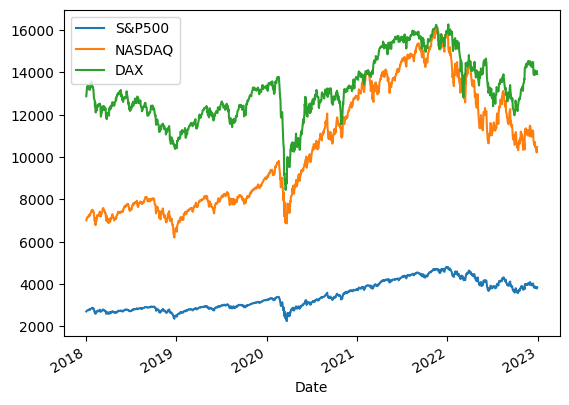

In [5]:
data_s_p_500.plot(label='S&P500')
data_nasdaq.plot(label='NASDAQ')
data_dax.plot(label='DAX')
plt.legend()
plt.show()


In [69]:
# Merge to DataFrame
df = pd.DataFrame({'s_p_500': data_s_p_500, 
                   'nas': data_nasdaq, 
                   'dax': data_dax.values[:1259]})

# 3. Split for train/test/validation and normalization

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-02 00:00:00-05:00 to 2022-12-30 00:00:00-05:00
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   s_p_500  1259 non-null   float64
 1   nas      1259 non-null   float64
 2   dax      1259 non-null   float64
dtypes: float64(3)
memory usage: 71.6 KB


In [71]:
df.head()

,s_p_500,nas,dax
Date,,,
2018-01-02 00:00:00-05:00,2695.810059,7006.899902,12871.389648
2018-01-03 00:00:00-05:00,2713.060059,7065.529785,12978.209961
2018-01-04 00:00:00-05:00,2723.989990,7077.910156,13167.889648
2018-01-05 00:00:00-05:00,2743.149902,7136.560059,13319.639648
2018-01-08 00:00:00-05:00,2747.709961,7157.390137,13367.780273


In [72]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [73]:
train_df.columns

Index(['s_p_500', 'nas', 'dax'], dtype='object')

In [74]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

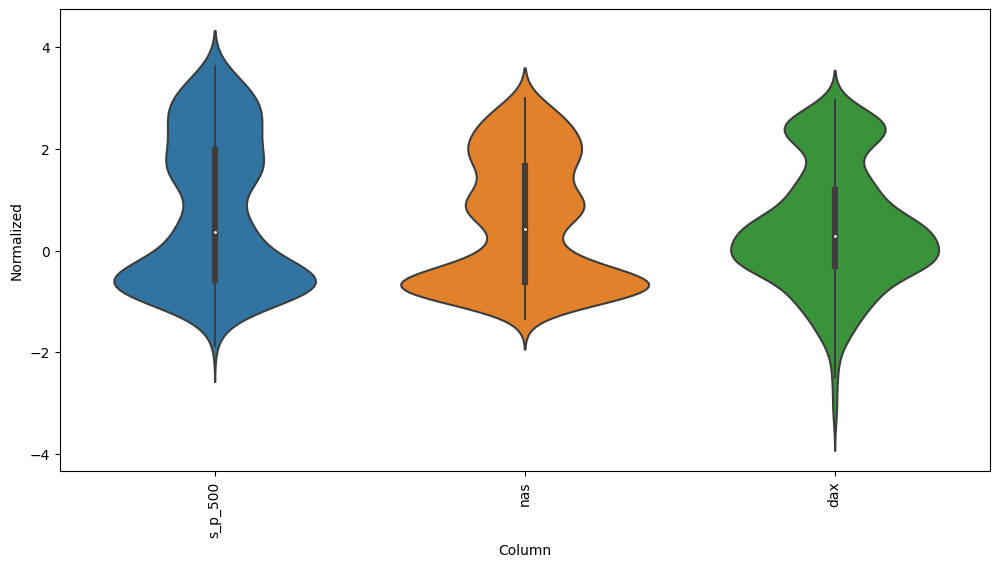

In [75]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# 4. DataWindow

In [76]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [77]:
# forecast for 24 hours ahead, taking into 24-hour history 
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['s_p_500'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['s_p_500']

In [78]:
# forecast for 1 hour ahead, taking into 6-hour history 
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['s_p_500'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['s_p_500']

In [79]:
w1.input_slice

slice(0, 24, None)

## Split window

In [80]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [81]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 3)
Inputs shape: (3, 6, 3)
Labels shape: (3, 1, 1)


In [104]:
w2.example = example_inputs, example_labels

In [154]:
def plot(self, model=None, plot_col='s_p_500', max_subplots=1):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            
            
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
            plt.errorbar(self.label_indices, predictions[n, :, label_col_index], 
                         yerr=np.abs(predictions[n, :, label_col_index])*0.1, fmt="o")

        if n == 0:
              plt.legend()

    plt.xlabel('Time')

WindowGenerator.plot = plot

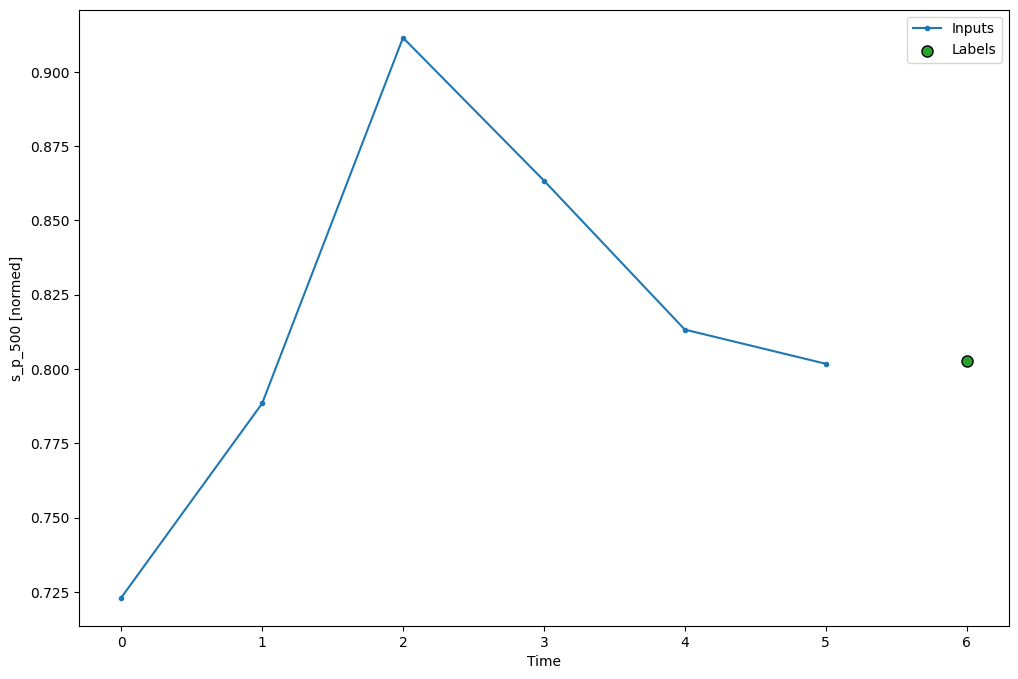

In [155]:
w2.plot()

# Create tf.DataSet

In [109]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [110]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [111]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [112]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 3)
Labels shape (batch, time, features): (32, 1, 1)


2023-01-24 21:10:03.934912: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# 5. Predict s_p_500 for an hour ahead

In [113]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['s_p_500'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['s_p_500']

In [114]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 3)
Labels shape (batch, time, features): (32, 1, 1)


## 5.1 Baseline

In [115]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [116]:
baseline = Baseline(label_index=column_indices['s_p_500'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

8/8 [==============================] - 0s 5ms/step - loss: 0.0133 - mean_absolute_error: 0.0875


2023-01-24 21:10:07.270379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


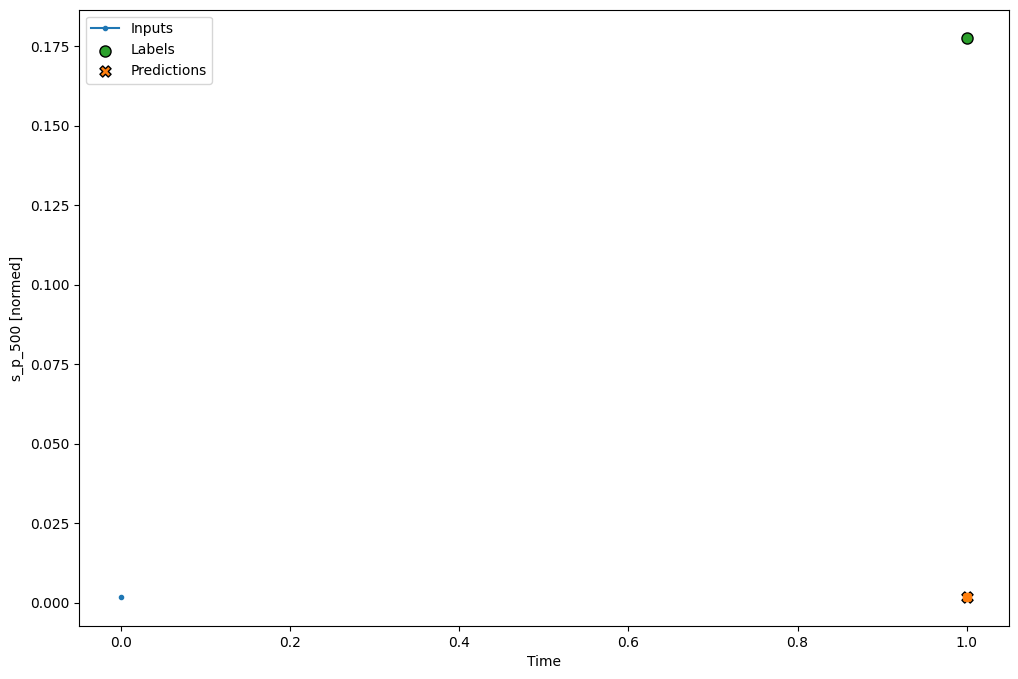

In [156]:
single_step_window.plot(baseline)

In [128]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['s_p_500'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['s_p_500']

In [120]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


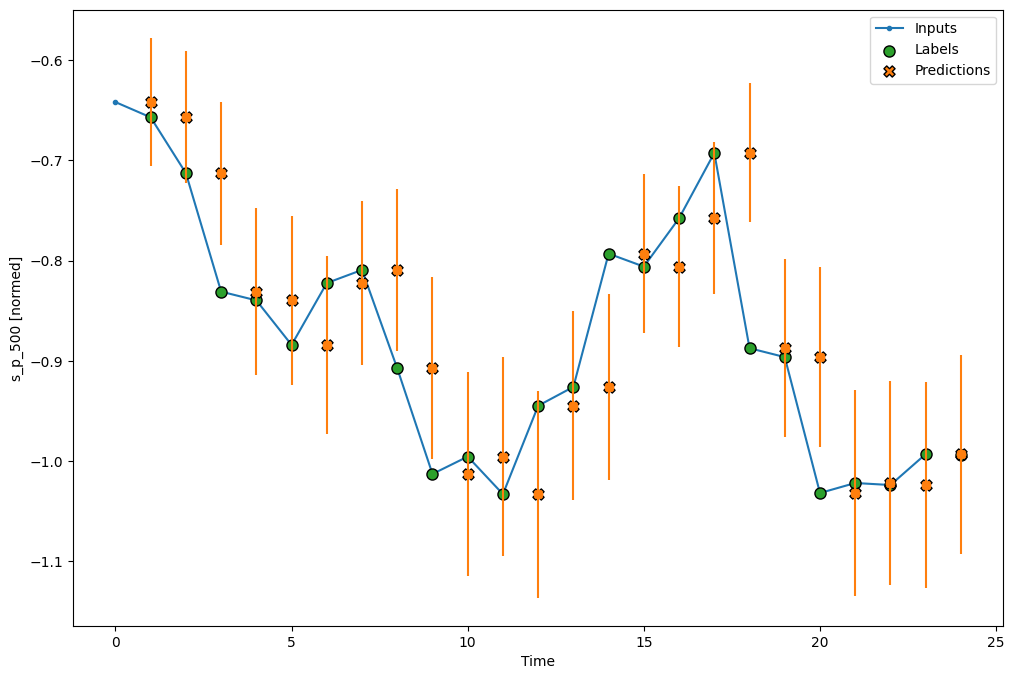

In [157]:
wide_window.plot(baseline)

## 5.2 Line model

In [138]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [139]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [140]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
18/28 [==================>...........] - ETA: 0s - loss: 0.1232 - mean_absolute_error: 0.2696

2023-01-24 21:36:34.260745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 11ms/step - loss: 0.1148 - mean_absolute_error: 0.2581 - val_loss: 1.6910 - val_mean_absolute_error: 1.2427
Epoch 2/20
 9/28 [========>.....................] - ETA: 0s - loss: 0.0994 - mean_absolute_error: 0.2431

2023-01-24 21:36:34.553721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 8ms/step - loss: 0.0871 - mean_absolute_error: 0.2271 - val_loss: 1.3335 - val_mean_absolute_error: 1.0858
Epoch 3/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0719 - mean_absolute_error: 0.2085 - val_loss: 1.0970 - val_mean_absolute_error: 0.9674
Epoch 4/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0640 - mean_absolute_error: 0.1995 - val_loss: 0.9590 - val_mean_absolute_error: 0.8911
Epoch 5/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0596 - mean_absolute_error: 0.1949 - val_loss: 0.8703 - val_mean_absolute_error: 0.8393
Epoch 6/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0567 - mean_absolute_error: 0.1915 - val_loss: 0.8239 - val_mean_absolute_error: 0.8121
Epoch 7/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0543 - mean_absolute_error: 0.1889 - val_loss: 0.7916 - val_mean_absolute_error: 0.7934
Epoch 8/20
28/28 [=====================

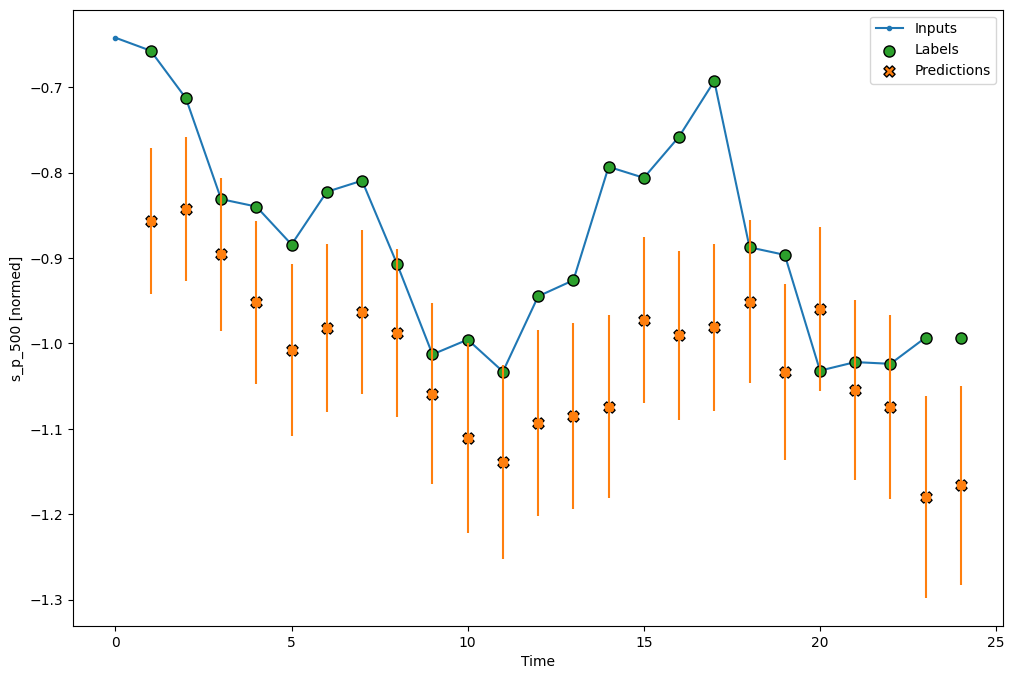

In [158]:
wide_window.plot(linear)

In [131]:
very_wide_window = WindowGenerator(
    input_width=120, label_width=120, shift=1,
    label_columns=['s_p_500'])

very_wide_window

Total window size: 121
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 

In [190]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [133]:
history = compile_and_fit(linear, very_wide_window)

val_performance['Linear'] = linear.evaluate(very_wide_window.val)
performance['Linear'] = linear.evaluate(very_wide_window.test, verbose=0)

Epoch 1/20
18/24 [=====================>........] - ETA: 0s - loss: 0.0819 - mean_absolute_error: 0.2140

2023-01-24 21:29:20.705053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 0s 12ms/step - loss: 0.0802 - mean_absolute_error: 0.2111 - val_loss: 1.9326 - val_mean_absolute_error: 1.3468
Epoch 2/20
10/24 [===========>..................] - ETA: 0s - loss: 0.0649 - mean_absolute_error: 0.1933

2023-01-24 21:29:20.983767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 0s 8ms/step - loss: 0.0657 - mean_absolute_error: 0.1933 - val_loss: 1.5754 - val_mean_absolute_error: 1.2046
Epoch 3/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0576 - mean_absolute_error: 0.1826 - val_loss: 1.3383 - val_mean_absolute_error: 1.1002
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0532 - mean_absolute_error: 0.1762 - val_loss: 1.1838 - val_mean_absolute_error: 1.0270
Epoch 5/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0502 - mean_absolute_error: 0.1716 - val_loss: 1.0907 - val_mean_absolute_error: 0.9811
Epoch 6/20
24/24 [==============================] - 0s 9ms/step - loss: 0.0479 - mean_absolute_error: 0.1688 - val_loss: 1.0394 - val_mean_absolute_error: 0.9559
Epoch 7/20
24/24 [==============================] - 0s 9ms/step - loss: 0.0459 - mean_absolute_error: 0.1667 - val_loss: 1.0058 - val_mean_absolute_error: 0.9398
Epoch 8/20
24/24 [=====================

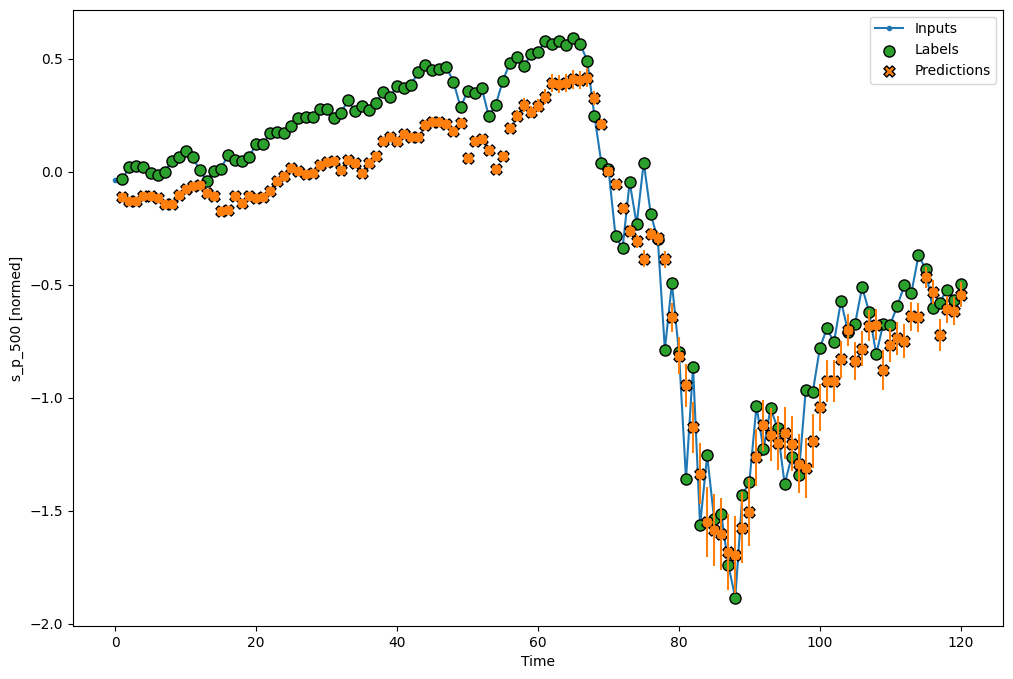

In [159]:
very_wide_window.plot(linear)

## 5.2 Dense model

In [160]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


2023-01-24 21:48:07.073033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 2s 19ms/step - loss: 0.4436 - mean_absolute_error: 0.4775 - val_loss: 0.2118 - val_mean_absolute_error: 0.3973
Epoch 2/20
 1/28 [>.............................] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0895

2023-01-24 21:48:08.410278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 14ms/step - loss: 0.0200 - mean_absolute_error: 0.1154 - val_loss: 0.1986 - val_mean_absolute_error: 0.3843
Epoch 3/20
28/28 [==============================] - 0s 14ms/step - loss: 0.0115 - mean_absolute_error: 0.0839 - val_loss: 0.1464 - val_mean_absolute_error: 0.3115
Epoch 4/20
28/28 [==============================] - 0s 13ms/step - loss: 0.0096 - mean_absolute_error: 0.0735 - val_loss: 0.1305 - val_mean_absolute_error: 0.2935
Epoch 5/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0087 - mean_absolute_error: 0.0677 - val_loss: 0.1325 - val_mean_absolute_error: 0.3008
Epoch 6/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1353 - mean_absolute_error: 0.3119


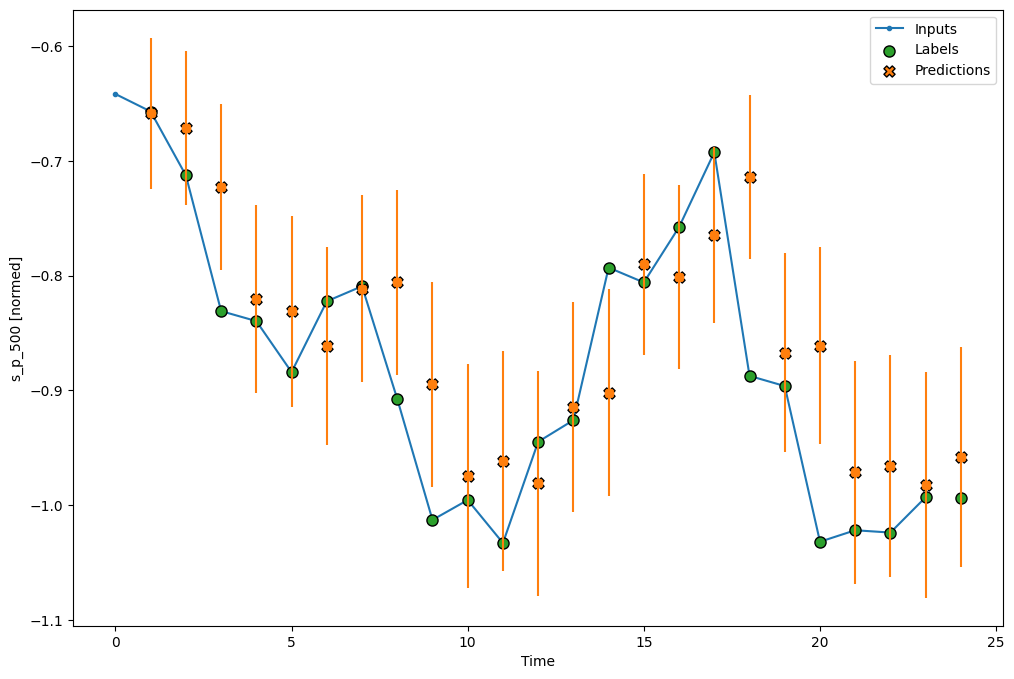

In [162]:
wide_window.plot(dense)

# 6. Multisteps

In [164]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['s_p_500'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['s_p_500']

In [165]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [167]:
history = compile_and_fit(multi_step_dense, conv_window)

# IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
 7/28 [======>.......................] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0693

2023-01-24 21:51:46.805396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 1s 12ms/step - loss: 0.0085 - mean_absolute_error: 0.0663 - val_loss: 0.0995 - val_mean_absolute_error: 0.2402
Epoch 2/20
10/28 [=========>....................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0629

2023-01-24 21:51:47.152884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 8ms/step - loss: 0.0077 - mean_absolute_error: 0.0626 - val_loss: 0.0811 - val_mean_absolute_error: 0.2132
Epoch 3/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0077 - mean_absolute_error: 0.0630 - val_loss: 0.0780 - val_mean_absolute_error: 0.2072
Epoch 4/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0072 - mean_absolute_error: 0.0609 - val_loss: 0.0863 - val_mean_absolute_error: 0.2268
Epoch 5/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0073 - mean_absolute_error: 0.0611 - val_loss: 0.0774 - val_mean_absolute_error: 0.2086
Epoch 6/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_absolute_error: 0.0581 - val_loss: 0.1008 - val_mean_absolute_error: 0.2607
Epoch 7/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0068 - mean_absolute_error: 0.0588 - val_loss: 0.0762 - val_mean_absolute_error: 0.2116
Epoch 8/20
28/28 [=====================

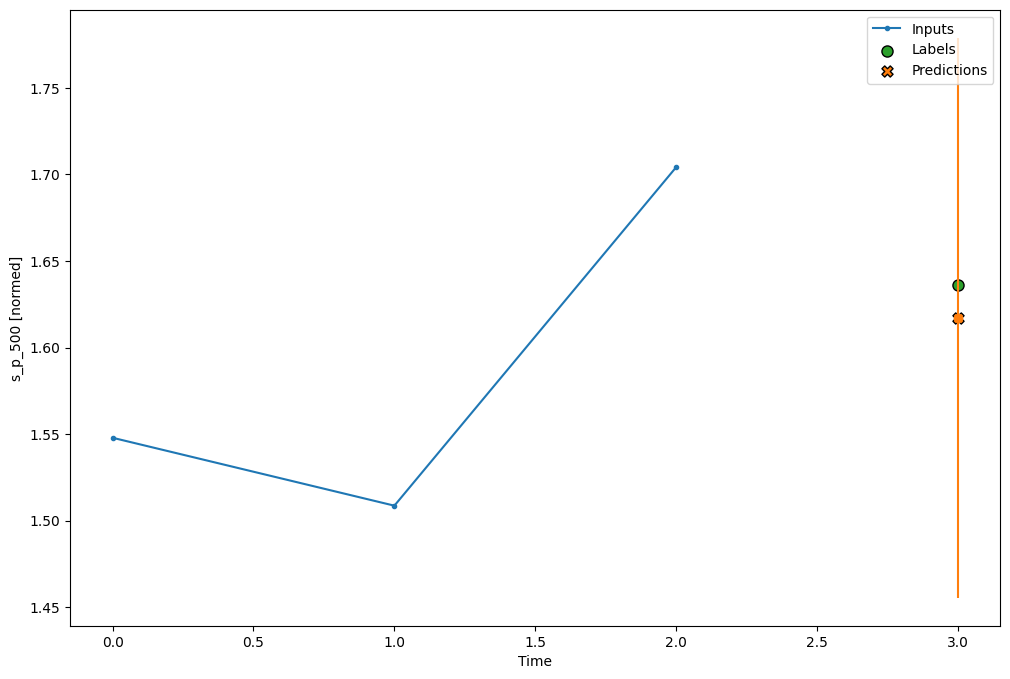

In [168]:
conv_window.plot(multi_step_dense)

# Convolutional

In [169]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [171]:
history = compile_and_fit(conv_model, conv_window)

# IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/20
 5/28 [====>.........................] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0625

2023-01-24 21:53:19.787167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 1s 18ms/step - loss: 0.0073 - mean_absolute_error: 0.0604 - val_loss: 0.0624 - val_mean_absolute_error: 0.1844
Epoch 2/20
 1/28 [>.............................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0572

2023-01-24 21:53:20.249087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 12ms/step - loss: 0.0071 - mean_absolute_error: 0.0592 - val_loss: 0.0597 - val_mean_absolute_error: 0.1813
Epoch 3/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0066 - mean_absolute_error: 0.0572 - val_loss: 0.0580 - val_mean_absolute_error: 0.1789
Epoch 4/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0069 - mean_absolute_error: 0.0586 - val_loss: 0.0953 - val_mean_absolute_error: 0.2620
Epoch 5/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0810 - mean_absolute_error: 0.2304


In [174]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['s_p_500'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['s_p_500']

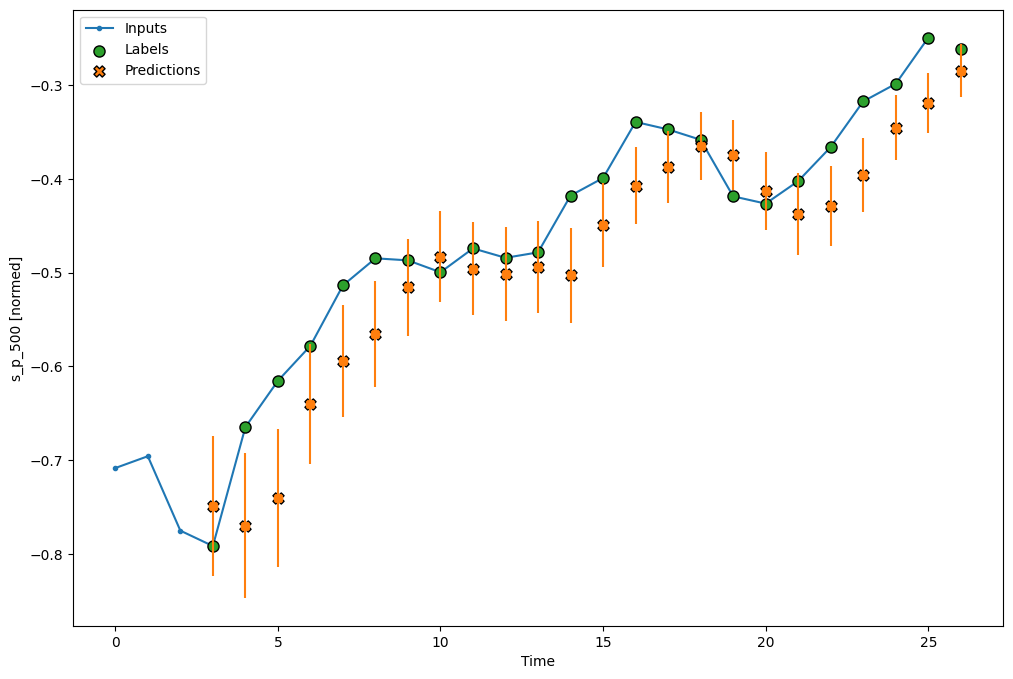

In [175]:
wide_conv_window.plot(conv_model)

# LSTM

In [183]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [188]:
history = compile_and_fit(lstm_model, very_wide_window)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(very_wide_window.val)
performance['LSTM'] = lstm_model.evaluate(very_wide_window.test, verbose=0)

Epoch 1/20


2023-01-24 21:59:28.296851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 21:59:28.391312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 21:59:28.624253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0581

2023-01-24 21:59:30.395998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 21:59:30.435511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 3s 81ms/step - loss: 0.0069 - mean_absolute_error: 0.0581 - val_loss: 0.1561 - val_mean_absolute_error: 0.3294
Epoch 2/20
24/24 [==============================] - 1s 37ms/step - loss: 0.0062 - mean_absolute_error: 0.0542 - val_loss: 0.1861 - val_mean_absolute_error: 0.3717
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 0.1931 - mean_absolute_error: 0.3811


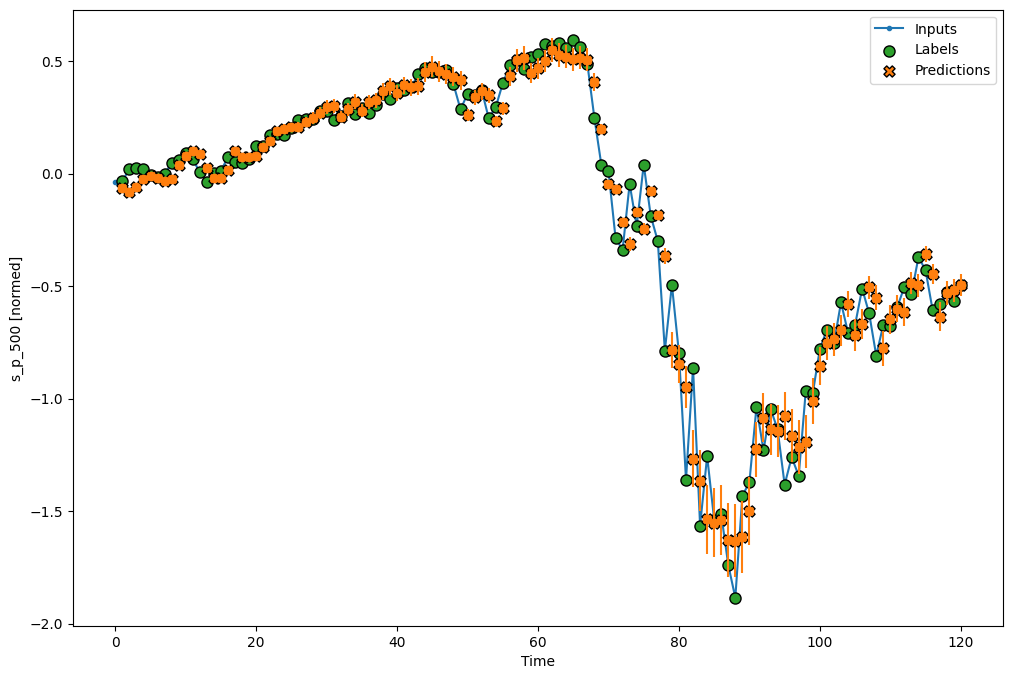

In [189]:
very_wide_window.plot(lstm_model)

TODO: change to real values and build traiding model on this base